SKRYPT KTÓRY DLA WYBRANEJ ZMIENNEJ TWORZY AUTOARIME WRAZ Z PRZEDZIALAMI UFNOSCI 

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima



In [ ]:
df = pd.read_csv(r'data\wdi_fertility_data_prepped.csv')

In [7]:

arima_models_info = {}
countries = df['country_name'].unique()
results = []
var = 'total_fertility_rate'

# Liczba lat do prognozy
forecast_years = 5

for country in countries:
    country_data = df[df['country_name'] == country].sort_values(by='year')
    max_year = country_data['year'].max()
    
    variable_data = country_data[['year', var]].dropna()
    y = variable_data[var].values
    
    if len(y) < 2:
        arima_models_info[(country, var)] = 'Brak danych do modelowania'
        for year_offset in range(1, forecast_years + 1):
            forecast_year = max_year + year_offset
            results.append({
                'country_name': country,
                'year': forecast_year,
                f'{var}_ARIMA': None,
                f'{var}_Lower_CI': None,
                f'{var}_Upper_CI': None,
            })
        continue

    # ARIMA
    try:
        arima_model = auto_arima(
            y, 
            seasonal=False, 
            trace=False, 
            error_action='ignore', 
            suppress_warnings=True
        )
        best_order = arima_model.order
        arima_models_info[(country, var)] = f'ARIMA({best_order[0]}, {best_order[1]}, {best_order[2]})'
        
        forecast, conf_int = arima_model.predict(n_periods=forecast_years, return_conf_int=True)
        
        for year_offset, (forecast_value, ci) in enumerate(zip(forecast, conf_int), start=1):
            forecast_year = max_year + year_offset
            results.append({
                'country_name': country,
                'year': forecast_year,
                f'{var}_ARIMA': forecast_value,
                f'{var}_Lower_CI': ci[0],  # Dolny przedział ufności
                f'{var}_Upper_CI': ci[1],  # Górny przedział ufności
            })
    except Exception as e:
        arima_models_info[(country, var)] = f'Błąd: {str(e)}'
        for year_offset in range(1, forecast_years + 1):
            forecast_year = max_year + year_offset
            results.append({
                'country_name': country,
                'year': forecast_year,
                f'{var}_ARIMA': None,
                f'{var}_Lower_CI': None,
                f'{var}_Upper_CI': None,
            })

forecast_df = pd.DataFrame(results)


In [8]:

def plot_forecasts(df, forecast_df, country, var):
    country_data = df[df['country_name'] == country].sort_values(by='year')
    country_forecast = forecast_df[forecast_df['country_name'] == country].sort_values(by='year')

    plt.figure(figsize=(12, 6))
    plt.plot(country_data['year'], country_data[var], label='Dane historyczne', marker='o', color='blue')
    plt.plot(country_forecast['year'], country_forecast[f'{var}_ARIMA'], label='Prognoza', marker='o', color='green')
    plt.fill_between(
        country_forecast['year'],
        country_forecast[f'{var}_Lower_CI'],
        country_forecast[f'{var}_Upper_CI'],
        color='lightgreen',
        alpha=0.5,
        label='Przedziały ufności'
    )

    plt.title(f'{country}')
    plt.xlabel('Rok')
    plt.ylabel(var)
    plt.axvline(x=country_data['year'].max(), color='gray', linestyle='--')
    plt.legend()
    plt.grid()

    plt.show()



Argentina, najlepszy model: ARIMA(0, 1, 2)


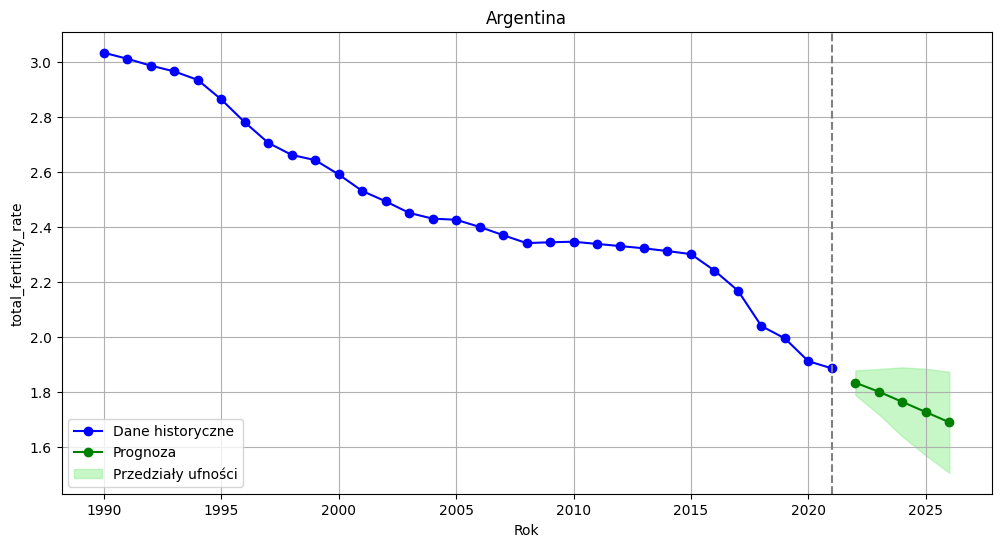

Brazil, najlepszy model: ARIMA(0, 2, 1)


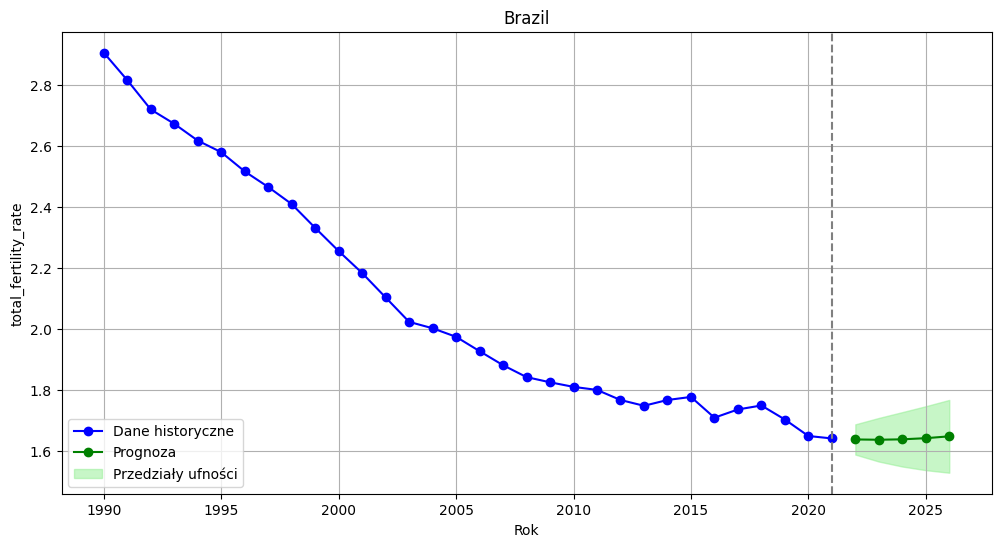

France, najlepszy model: ARIMA(0, 1, 0)


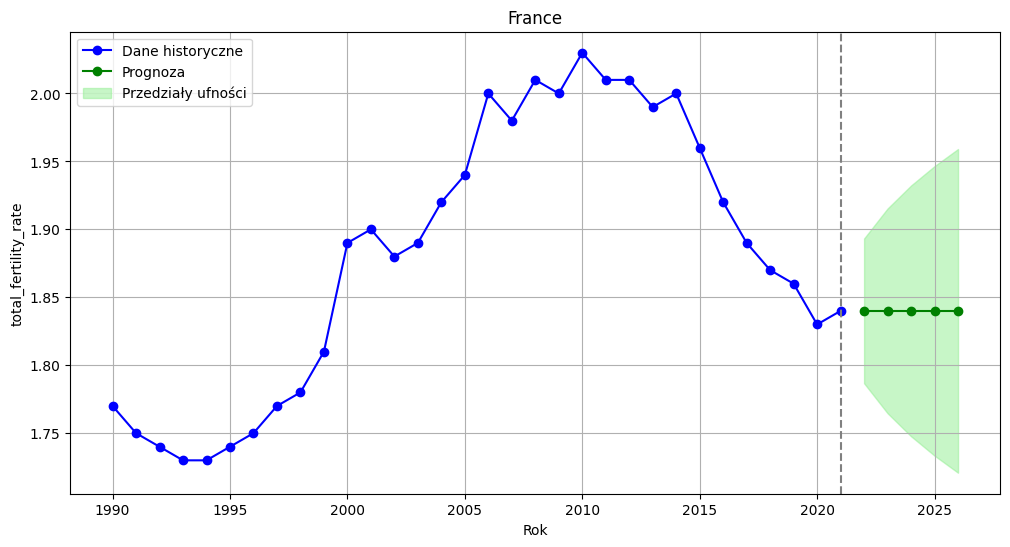

Germany, najlepszy model: ARIMA(0, 1, 0)


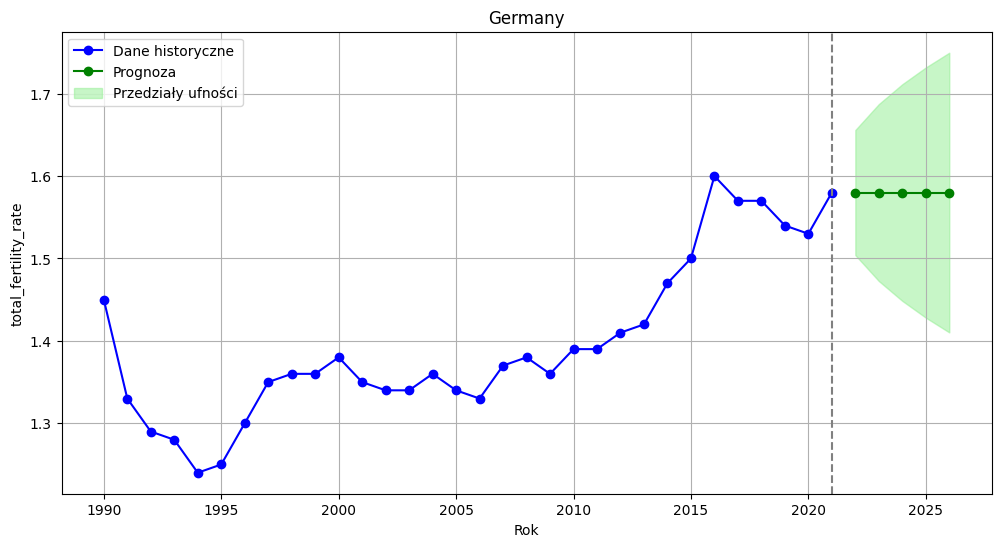

Poland, najlepszy model: ARIMA(1, 2, 0)


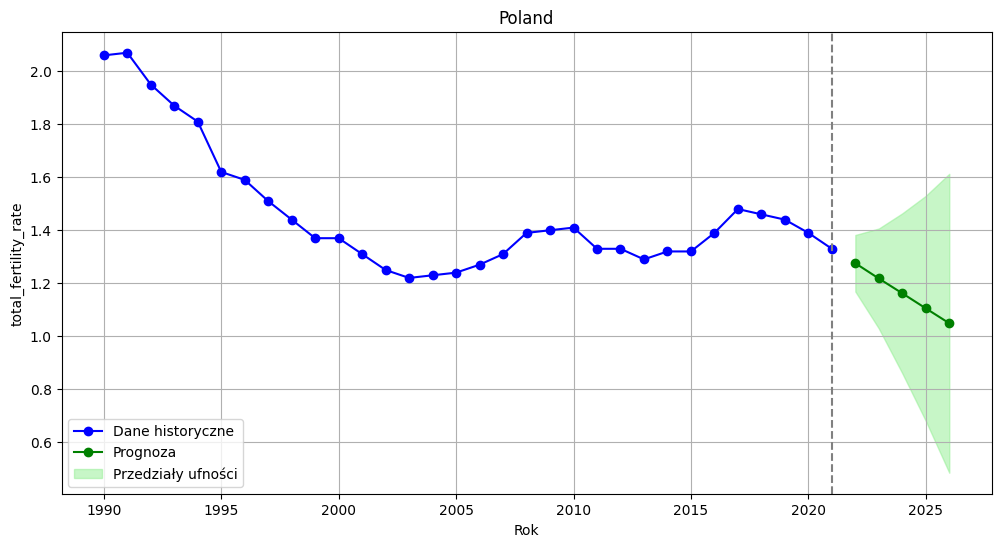

Nigeria, najlepszy model: ARIMA(1, 1, 1)


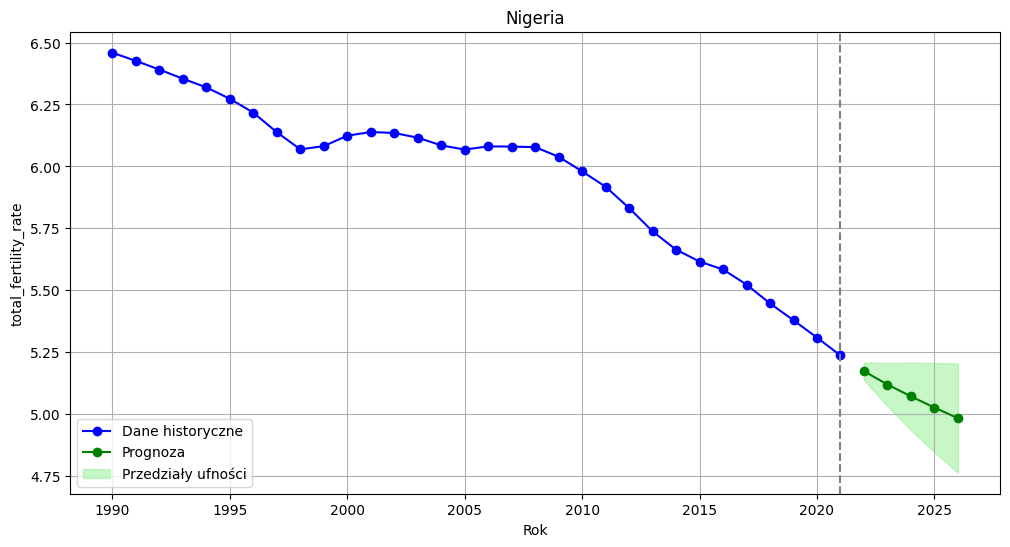

Kenya, najlepszy model: ARIMA(2, 1, 0)


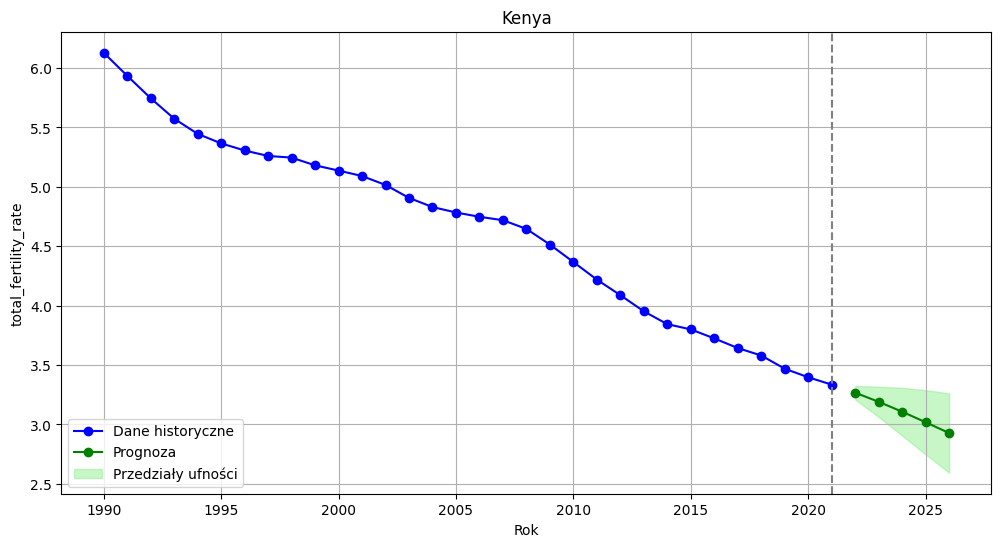

United Kingdom, najlepszy model: ARIMA(2, 0, 2)


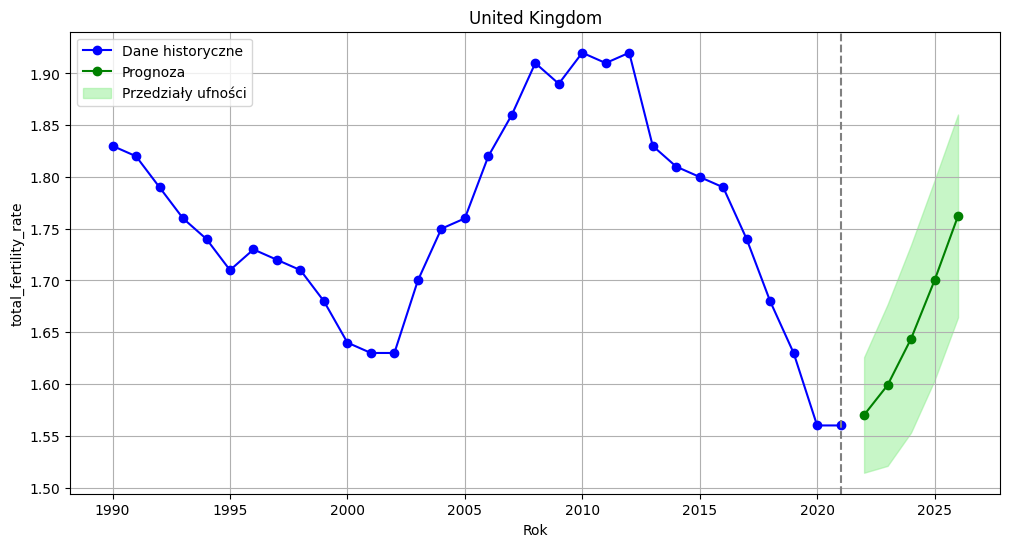

China, najlepszy model: ARIMA(3, 0, 0)


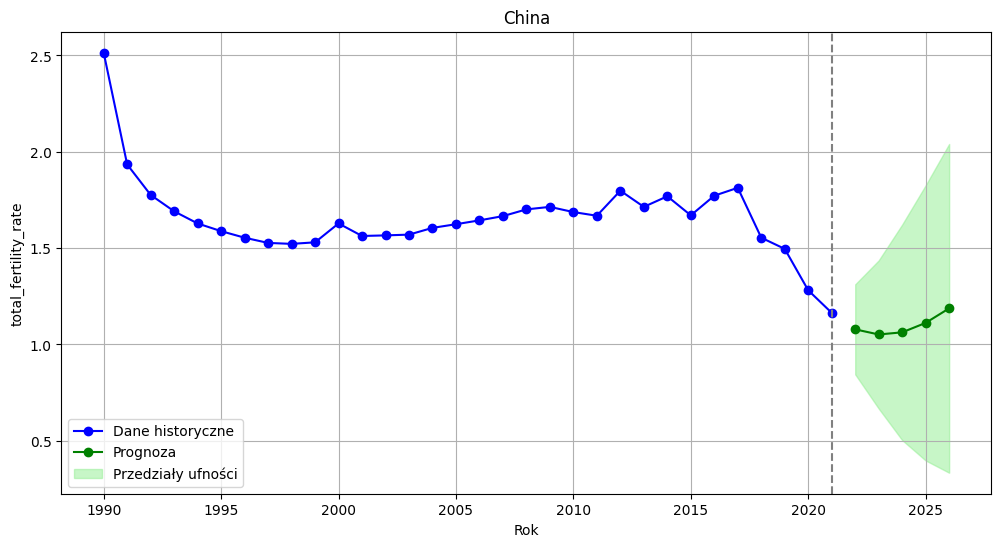

Japan, najlepszy model: ARIMA(1, 0, 2)


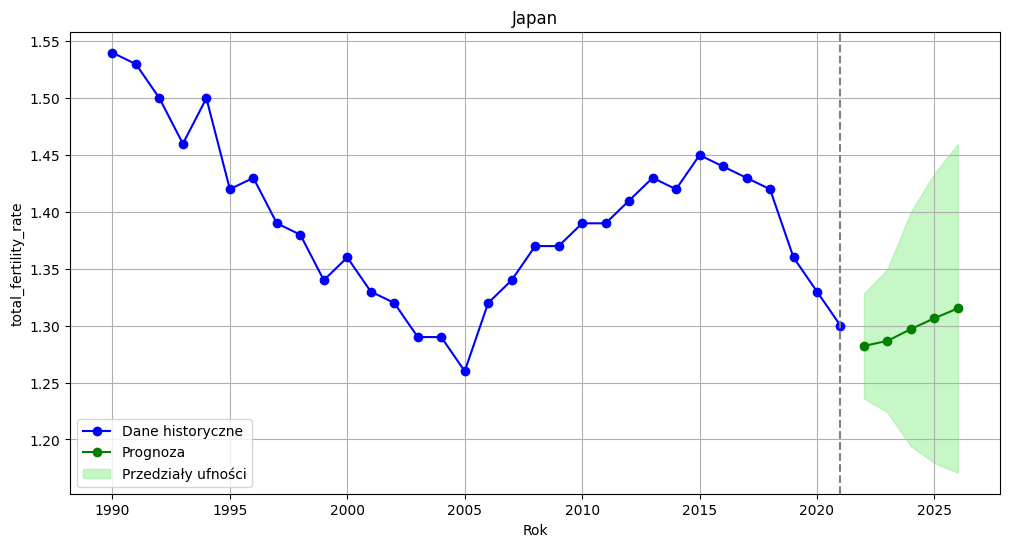

In [9]:
for country in countries:
    print(f"{country}, najlepszy model: {arima_models_info[(country, 'total_fertility_rate')]}")
    plot_forecasts(df, forecast_df, country, var='total_fertility_rate')
